<a href="https://colab.research.google.com/github/jayantmhr/Jayant-Project-1/blob/main/Multi_Stock_Momentum_Strategy_with_RSI_Filter_%26_Out_of_Sample_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


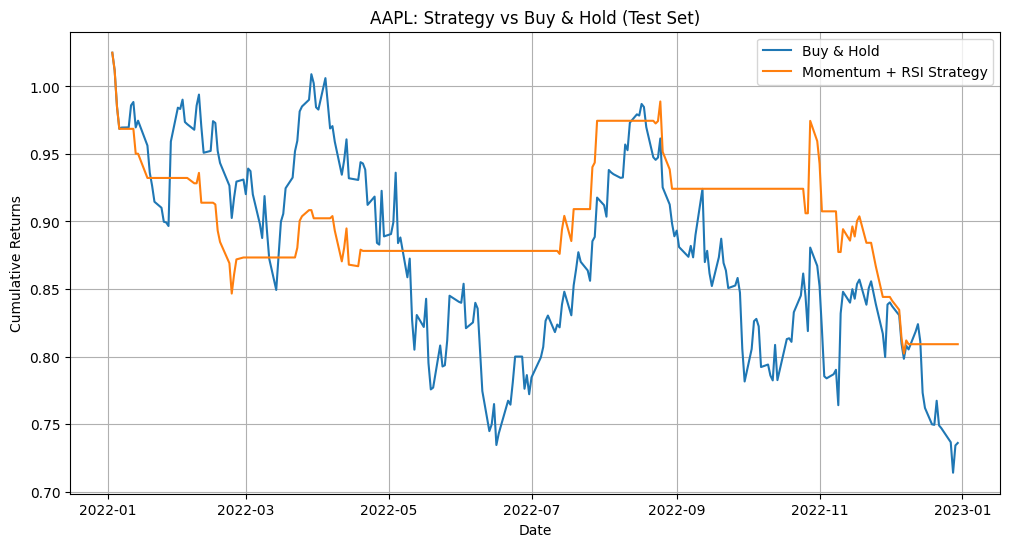

[*********************100%***********************]  1 of 1 completed


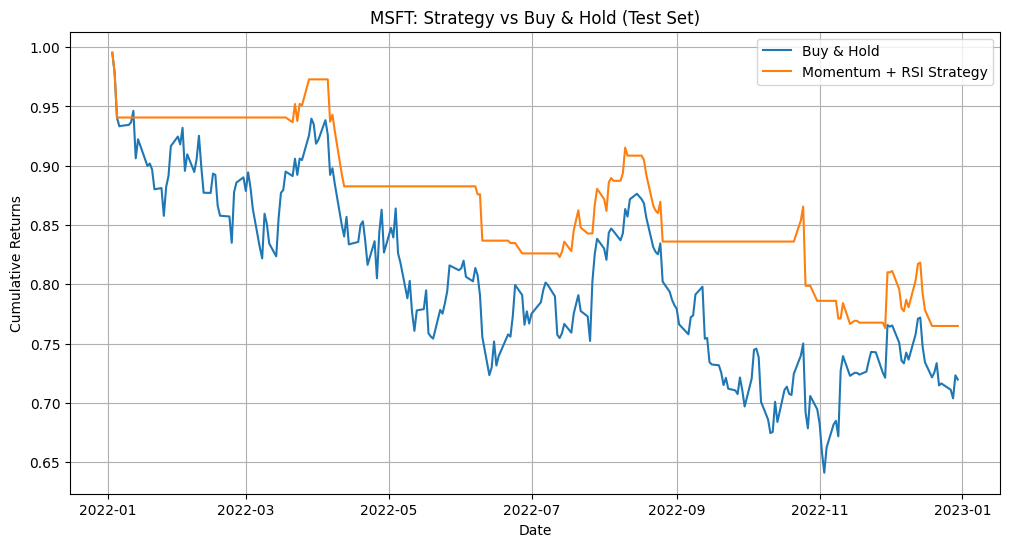

[*********************100%***********************]  1 of 1 completed


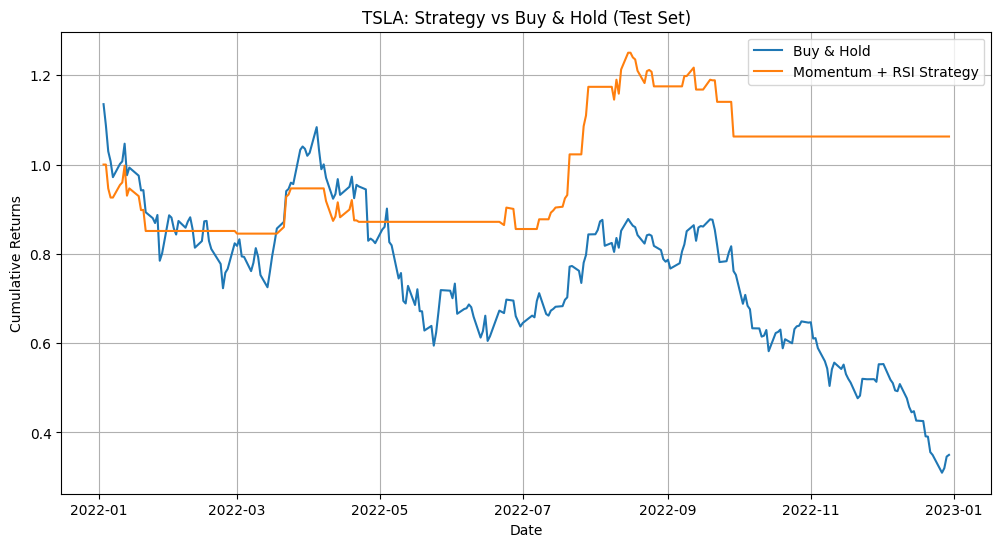

[*********************100%***********************]  1 of 1 completed


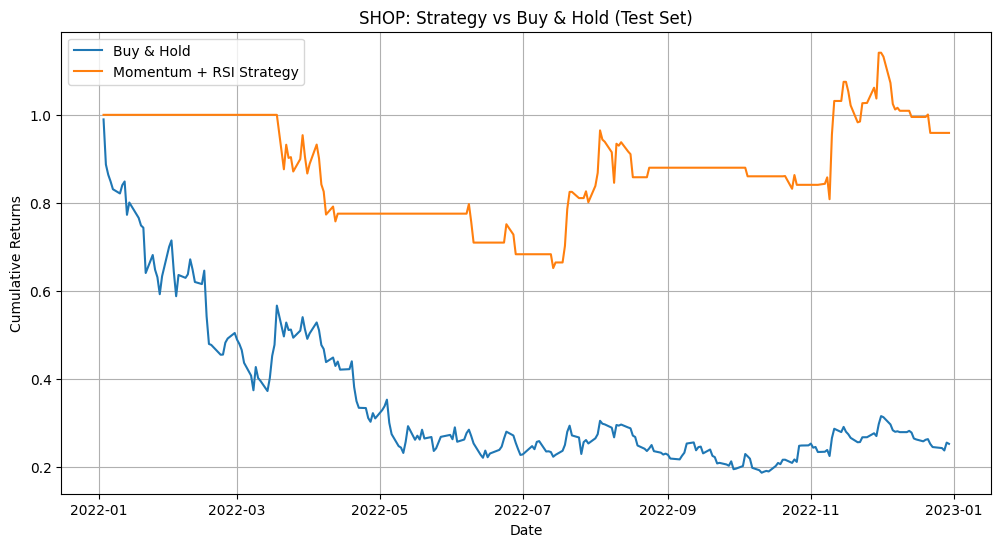

📊 Performance Summary:
  Ticker  Sharpe Ratio  Max Drawdown  Volatility  Final Strategy Return  \
0   AAPL         -1.22          0.22        0.16                   0.81   
1   MSFT         -1.44          0.23        0.18                   0.76   
2   TSLA          0.36          0.19        0.27                   1.06   
3   SHOP          0.12          0.35        0.44                   0.96   

   Final Market Return  
0                 0.74  
1                 0.72  
2                 0.35  
3                 0.25  


In [2]:
# Install in Colab (only needed once)
!pip install yfinance matplotlib

# Import packages
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define stocks and time range
tickers = ['AAPL', 'MSFT', 'TSLA', 'SHOP']
train_start = '2018-01-01'
train_end = '2021-12-31'
test_start = '2022-01-01'
test_end = '2023-01-01'

# RSI function
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = np.where(avg_loss == 0, np.inf, avg_gain / avg_loss)
    return 100 - (100 / (1 + rs))

# Results container
final_results = []

for ticker in tickers:
    data = yf.download(ticker, start=train_start, end=test_end)

    # Use 'Adj Close' if available, otherwise 'Close'
    price_column = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
    data['Returns'] = data[price_column].pct_change()
    data['Momentum_20'] = data[price_column].pct_change(20)
    data['RSI'] = calculate_rsi(data[price_column])

    # Strategy: momentum + RSI
    data['Signal'] = np.where((data['Momentum_20'] > 0) & (data['RSI'] < 70), 1, 0)
    data['Strategy_Returns'] = data['Signal'].shift(1) * data['Returns']

    # Ensure test period has data
    test = data.loc[test_start:test_end].copy()
    if test.empty:
        print(f"⚠️ No test data for {ticker}. Skipping.")
        continue

    # Cumulative returns
    test['Cumulative_Market'] = (1 + test['Returns']).cumprod()
    test['Cumulative_Strategy'] = (1 + test['Strategy_Returns'].fillna(0)).cumprod()

    # Risk Metrics
    strategy_returns = test['Strategy_Returns'].dropna()
    sharpe = (strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)) if not strategy_returns.empty else np.nan
    volatility = (strategy_returns.std() * np.sqrt(252)) if not strategy_returns.empty else np.nan
    max_drawdown = (test['Cumulative_Strategy'].cummax() - test['Cumulative_Strategy']).max()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(test['Cumulative_Market'], label='Buy & Hold')
    plt.plot(test['Cumulative_Strategy'], label='Momentum + RSI Strategy')
    plt.title(f'{ticker}: Strategy vs Buy & Hold (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Append results
    final_results.append({
        'Ticker': ticker,
        'Sharpe Ratio': round(sharpe, 2) if not np.isnan(sharpe) else 'N/A',
        'Max Drawdown': round(max_drawdown, 2),
        'Volatility': round(volatility, 2) if not np.isnan(volatility) else 'N/A',
        'Final Strategy Return': round(test['Cumulative_Strategy'].iloc[-1], 2),
        'Final Market Return': round(test['Cumulative_Market'].iloc[-1], 2)
    })

# Summary Table
results_df = pd.DataFrame(final_results)
print("📊 Performance Summary:")
print(results_df)
